# Analysis

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel, chisquare

## T-test and Chi-Squared test

In [7]:
alpha = 0.05

def load_pair_df(target):

    super_path = "cnn_prediction.csv"
    ts2_path   = "ts2vec_prediction.csv"

    df_super = pd.read_csv(super_path)
    df_ts2   = pd.read_csv(ts2_path)

    n = min(len(df_super), len(df_ts2))
    df_super = df_super.iloc[:n].reset_index(drop=True)
    df_ts2   = df_ts2.iloc[:n].reset_index(drop=True)

    df = pd.DataFrame({
        "gest_age_weeks": df_super["gest_age_weeks"].to_numpy(),
        "ae_super": np.abs(df_super["y_pred"].to_numpy() - df_super["y_true"].to_numpy()),
        "ae_ts2":   np.abs(df_ts2["y_pred"].to_numpy()   - df_ts2["y_true"].to_numpy()),
    })

    return df

week_mae = {}
ratio_results = {}

for target in ["onset"]:

    df = load_pair_df(target)
    ae_super = df["ae_super"].to_numpy()
    ae_ts2   = df["ae_ts2"].to_numpy()

    t_stat, p_t = ttest_rel(ae_super, ae_ts2)

    diff = ae_super - ae_ts2
    n_super_better = int((diff < 0).sum())
    n_ts2_better   = int((diff > 0).sum())

    if n_super_better + n_ts2_better > 0:
        f_obs = np.array([n_super_better, n_ts2_better])
        chi_stat, p_chi = chisquare(f_obs)
    else:
        chi_stat, p_chi = np.nan, np.nan

    mae_super = ae_super.mean()
    mae_ts2   = ae_ts2.mean()

    r3_super = float((ae_super <= 3).mean())
    r3_ts2   = float((ae_ts2   <= 3).mean())
    r5_super = float((ae_super <= 5).mean())
    r5_ts2   = float((ae_ts2   <= 5).mean())

    ratio_results[target] = {
        "SuperCNN": {"within_3": r3_super, "within_5": r5_super},
        "TS2Vec":   {"within_3": r3_ts2,   "within_5": r5_ts2},
    }

    if p_t < alpha:
        if mae_super < mae_ts2:
            t_sentence = f"{target}: t-test p={p_t:.2e}, SuperCNN MAE < TS2Vec."
        else:
            t_sentence = f"{target}: t-test p={p_t:.2e}, TS2Vec MAE < SuperCNN."
    else:
        t_sentence = f"{target}: t-test p={p_t:.2e}, MAE difference not significant."

    if np.isnan(p_chi):
        chi_sentence = f"{target}: chi-square not computed (no non-tied wins)."
    else:
        if p_chi < alpha:
            if n_super_better > n_ts2_better:
                chi_sentence = f"{target}: chi-square p={p_chi:.2e}, SuperCNN wins more cases."
            else:
                chi_sentence = f"{target}: chi-square p={p_chi:.2e}, TS2Vec wins more cases."
        else:
            chi_sentence = f"{target}: chi-square p={p_chi:.2e}, win counts not different."

    print(f"\n=== {target} ===")
    print(f"SuperCNN MAE={mae_super:.3f}, TS2Vec MAE={mae_ts2:.3f}")
    print(t_sentence)
    print(chi_sentence)
    print(f"{target}: ≤3d SuperCNN={r3_super:.3f}, TS2Vec={r3_ts2:.3f}; "
          f"≤5d SuperCNN={r5_super:.3f}, TS2Vec={r5_ts2:.3f}.")

    wk = df.groupby("gest_age_weeks").agg(
        mae_super=("ae_super", "mean"),
        mae_ts2=("ae_ts2", "mean")
    ).reset_index()
    week_mae[target] = wk

for target in ["onset"]:
    wk = week_mae[target]
    weeks = wk["gest_age_weeks"].to_numpy()
    mae_super = wk["mae_super"].to_numpy()
    mae_ts2   = wk["mae_ts2"].to_numpy()

    x = np.arange(len(weeks))
    w = 0.35

    plt.figure(figsize=(10, 5))
    plt.bar(x - w/2, mae_super, width=w, color="tab:blue", label="SuperCNN")
    plt.bar(x + w/2, mae_ts2,   width=w, color="gold",    label="TS2Vec")
    plt.xticks(x, weeks)
    plt.xlabel("Gestational age (weeks)")
    plt.ylabel("MAE (days)")
    plt.title(f"{target} MAE by gestational week")
    plt.legend()
    plt.tight_layout()

    out_path = os.path.join(f"{target}_MAE_by_week.png")
    plt.savefig(out_path, dpi=200)
    plt.close()


=== onset ===
SuperCNN MAE=6.525, TS2Vec MAE=7.117
onset: t-test p=2.85e-05, SuperCNN MAE < TS2Vec.
onset: chi-square p=2.73e-12, SuperCNN wins more cases.
onset: ≤3d SuperCNN=0.284, TS2Vec=0.224; ≤5d SuperCNN=0.480, TS2Vec=0.374.


## Bland-Altman 

In [8]:
file_map = {
    ("SuperCNN", "onset"): "cnn_prediction.csv",
    ("TS2Vec",   "onset"): "ts2vec_prediction.csv",
    # ("SuperCNN", "add"):   os.path.join(BASE, "prediction_superCNN_add.csv"),
    # ("TS2Vec",   "add"):   os.path.join(BASE, "prediction_TS2Vec_add.csv"),
}

for model, target in [
    ("SuperCNN", "onset"),
    # ("SuperCNN", "add"),
    ("TS2Vec",   "onset"),
    # ("TS2Vec",   "add")
]:
    path = file_map[(model, target)]
    df = pd.read_csv(path)

    y_true = df["y_true"].to_numpy()
    y_pred = df["y_pred"].to_numpy()

    mean_vals = 0.5 * (y_true + y_pred)
    diff_vals = y_pred - y_true

    bias = diff_vals.mean()
    sd = diff_vals.std(ddof=1)
    loa_upper = bias + 1.96 * sd
    loa_lower = bias - 1.96 * sd

    print(f"\n{model} - {target}")
    print(f"Bias = {bias:.3f}, SD = {sd:.3f}, LoA = [{loa_lower:.3f}, {loa_upper:.3f}]")

    plt.figure(figsize=(6, 5))
    plt.scatter(mean_vals, diff_vals, s=8, alpha=0.5)
    plt.axhline(bias, color="red", linestyle="--", label=f"Bias = {bias:.2f}")
    plt.axhline(loa_upper, color="gray", linestyle="--", label=f"+1.96 SD = {loa_upper:.2f}")
    plt.axhline(loa_lower, color="gray", linestyle="--", label=f"-1.96 SD = {loa_lower:.2f}")
    plt.xlabel("Mean of true and predicted (days)")
    plt.ylabel("Difference (pred - true, days)")
    plt.title(f"Bland-Altman: {model} ({target})")
    plt.legend()
    plt.tight_layout()
    out_path = os.path.join(f"{model}_{target}_BlandAltman.png")
    plt.savefig(out_path, dpi=200)
    plt.close()



SuperCNN - onset
Bias = 0.247, SD = 8.944, LoA = [-17.283, 17.776]

TS2Vec - onset
Bias = -0.369, SD = 9.159, LoA = [-18.321, 17.583]


In [11]:
files = [
    # "prediction_superCNN_add.csv",
    "cnn_prediction.csv",
    # "prediction_TS2Vec_add.csv",
    "ts2vec_prediction.csv",
]

for path in files:
    df = pd.read_csv(path)
    df_small = df[df["y_true"] <= 3].copy()

    plt.figure(figsize=(8, 5))
    plt.scatter(df_small["gest_age_weeks"], df_small["y_true"], label="y_true", alpha=0.7)
    plt.scatter(df_small["gest_age_weeks"], df_small["y_pred"], label="y_pred", alpha=0.7)
    plt.xlabel("Gestational age (weeks)")
    plt.ylabel("Onset time")
    plt.title(f"{path} | y_true ≤ 3")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    out_path = path.replace(".csv", "_ytrue_le3.png")
    plt.savefig(out_path, dpi=300)
    plt.close()

## Condusion Matrix analysis


### SuperCNN - onset 按 gest_age_weeks 分层分析 (true<3.0, pred<4.0 天) ###

--- GA = 29 weeks ---
Samples = 25, Positives (y_true=1) = 0, Positive ratio = 0.0000
TP=0, TN=25, FP=0, FN=0
Sensitivity (TPR): nan
Specificity (TNR): 1.000
PPV: nan
NPV: 1.000
Accuracy: 1.000


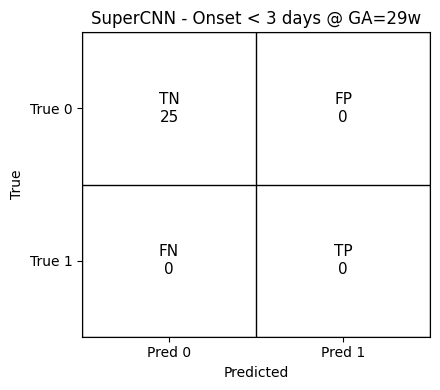


--- GA = 30 weeks ---
Samples = 72, Positives (y_true=1) = 0, Positive ratio = 0.0000
TP=0, TN=72, FP=0, FN=0
Sensitivity (TPR): nan
Specificity (TNR): 1.000
PPV: nan
NPV: 1.000
Accuracy: 1.000


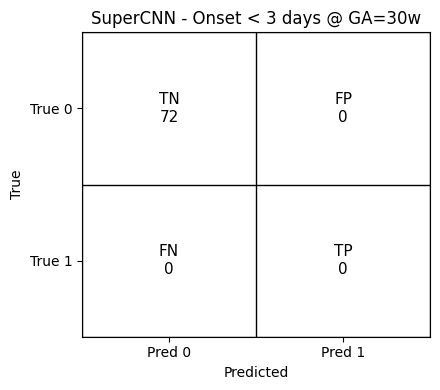


--- GA = 31 weeks ---
Samples = 105, Positives (y_true=1) = 0, Positive ratio = 0.0000
TP=0, TN=105, FP=0, FN=0
Sensitivity (TPR): nan
Specificity (TNR): 1.000
PPV: nan
NPV: 1.000
Accuracy: 1.000


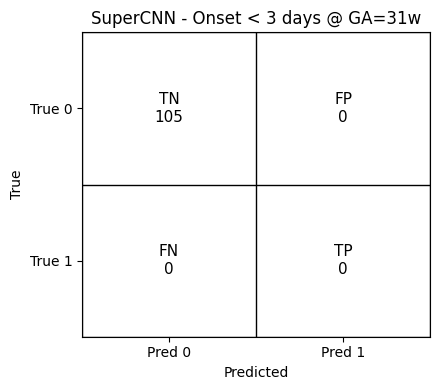


--- GA = 32 weeks ---
Samples = 157, Positives (y_true=1) = 0, Positive ratio = 0.0000
TP=0, TN=157, FP=0, FN=0
Sensitivity (TPR): nan
Specificity (TNR): 1.000
PPV: nan
NPV: 1.000
Accuracy: 1.000


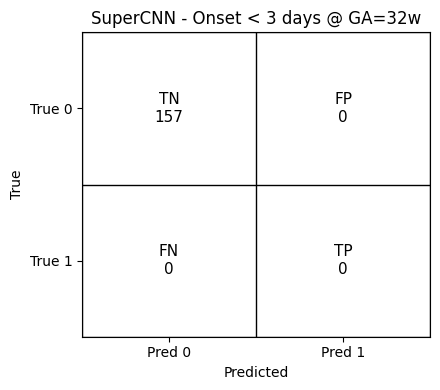


--- GA = 33 weeks ---
Samples = 254, Positives (y_true=1) = 4, Positive ratio = 0.0157
TP=0, TN=250, FP=0, FN=4
Sensitivity (TPR): 0.000
Specificity (TNR): 1.000
PPV: nan
NPV: 0.984
Accuracy: 0.984


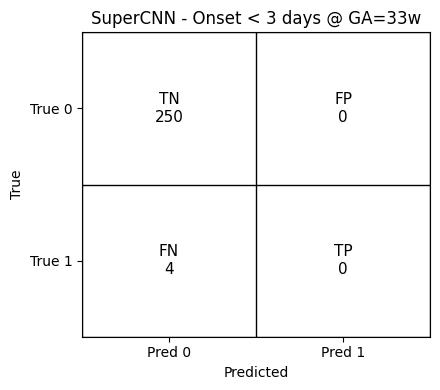


--- GA = 34 weeks ---
Samples = 313, Positives (y_true=1) = 0, Positive ratio = 0.0000
TP=0, TN=313, FP=0, FN=0
Sensitivity (TPR): nan
Specificity (TNR): 1.000
PPV: nan
NPV: 1.000
Accuracy: 1.000


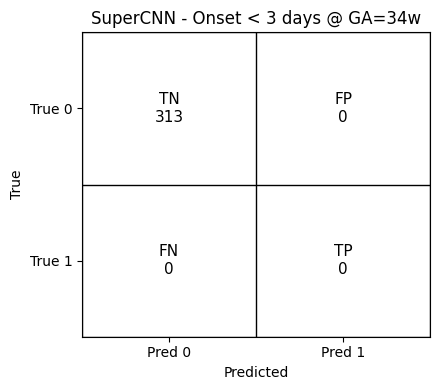


--- GA = 35 weeks ---
Samples = 371, Positives (y_true=1) = 0, Positive ratio = 0.0000
TP=0, TN=371, FP=0, FN=0
Sensitivity (TPR): nan
Specificity (TNR): 1.000
PPV: nan
NPV: 1.000
Accuracy: 1.000


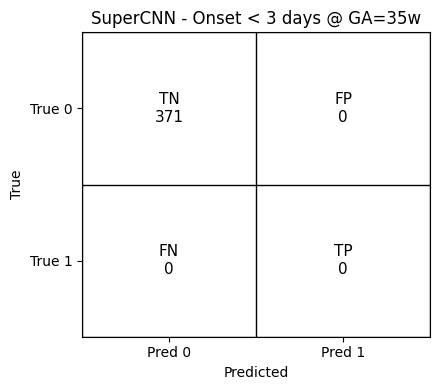


--- GA = 36 weeks ---
Samples = 443, Positives (y_true=1) = 0, Positive ratio = 0.0000
TP=0, TN=443, FP=0, FN=0
Sensitivity (TPR): nan
Specificity (TNR): 1.000
PPV: nan
NPV: 1.000
Accuracy: 1.000


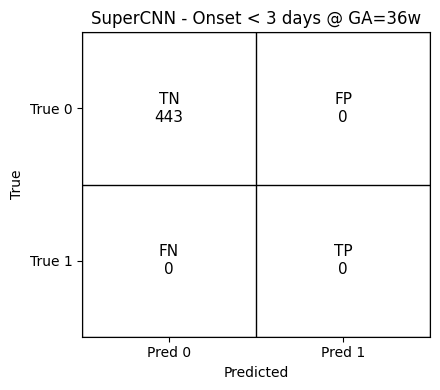


--- GA = 37 weeks ---
Samples = 503, Positives (y_true=1) = 10, Positive ratio = 0.0199
TP=0, TN=493, FP=0, FN=10
Sensitivity (TPR): 0.000
Specificity (TNR): 1.000
PPV: nan
NPV: 0.980
Accuracy: 0.980


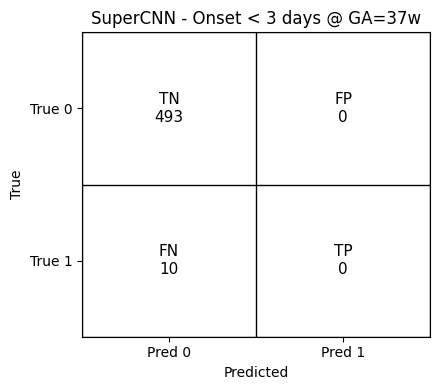


--- GA = 38 weeks ---
Samples = 544, Positives (y_true=1) = 19, Positive ratio = 0.0349
TP=0, TN=525, FP=0, FN=19
Sensitivity (TPR): 0.000
Specificity (TNR): 1.000
PPV: nan
NPV: 0.965
Accuracy: 0.965


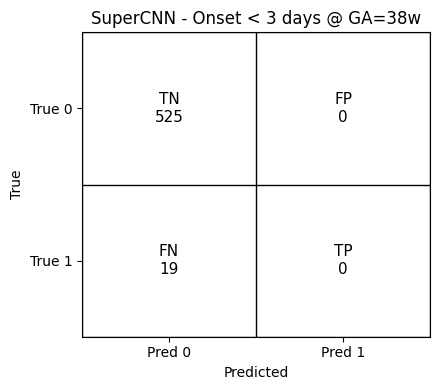


--- GA = 39 weeks ---
Samples = 463, Positives (y_true=1) = 77, Positive ratio = 0.1663
TP=2, TN=370, FP=16, FN=75
Sensitivity (TPR): 0.026
Specificity (TNR): 0.959
PPV: 0.111
NPV: 0.831
Accuracy: 0.803


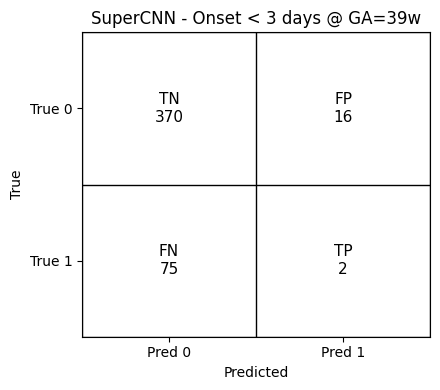


--- GA = 40 weeks ---
Samples = 321, Positives (y_true=1) = 72, Positive ratio = 0.2243
TP=36, TN=143, FP=106, FN=36
Sensitivity (TPR): 0.500
Specificity (TNR): 0.574
PPV: 0.254
NPV: 0.799
Accuracy: 0.558


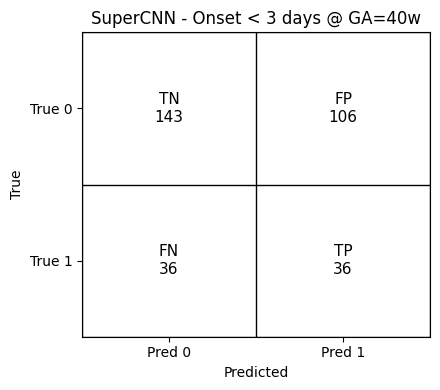


--- GA = 41 weeks ---
Samples = 89, Positives (y_true=1) = 45, Positive ratio = 0.5056
TP=45, TN=3, FP=41, FN=0
Sensitivity (TPR): 1.000
Specificity (TNR): 0.068
PPV: 0.523
NPV: 1.000
Accuracy: 0.539


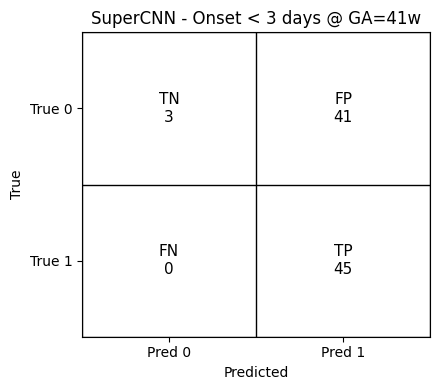


--- GA = 42 weeks ---
Samples = 1, Positives (y_true=1) = 1, Positive ratio = 1.0000
TP=1, TN=0, FP=0, FN=0
Sensitivity (TPR): 1.000
Specificity (TNR): nan
PPV: 1.000
NPV: nan
Accuracy: 1.000


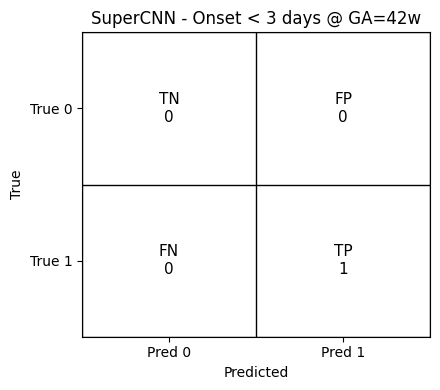


### TS2Vec - onset 按 gest_age_weeks 分层分析 (true<3.0, pred<4.0 天) ###

--- GA = 29 weeks ---
Samples = 25, Positives (y_true=1) = 0, Positive ratio = 0.0000
TP=0, TN=25, FP=0, FN=0
Sensitivity (TPR): nan
Specificity (TNR): 1.000
PPV: nan
NPV: 1.000
Accuracy: 1.000


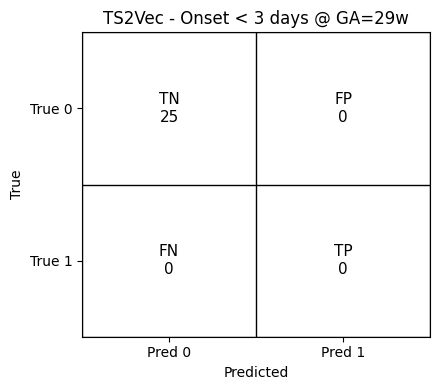


--- GA = 30 weeks ---
Samples = 72, Positives (y_true=1) = 0, Positive ratio = 0.0000
TP=0, TN=72, FP=0, FN=0
Sensitivity (TPR): nan
Specificity (TNR): 1.000
PPV: nan
NPV: 1.000
Accuracy: 1.000


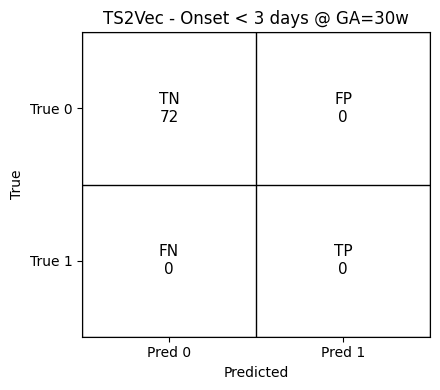


--- GA = 31 weeks ---
Samples = 105, Positives (y_true=1) = 0, Positive ratio = 0.0000
TP=0, TN=105, FP=0, FN=0
Sensitivity (TPR): nan
Specificity (TNR): 1.000
PPV: nan
NPV: 1.000
Accuracy: 1.000


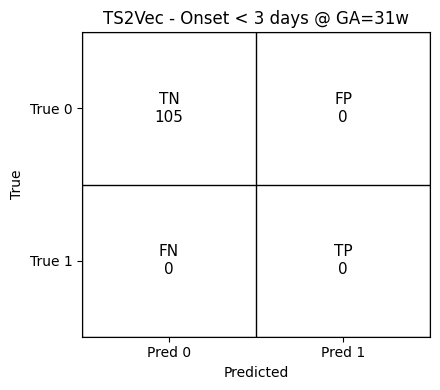


--- GA = 32 weeks ---
Samples = 157, Positives (y_true=1) = 0, Positive ratio = 0.0000
TP=0, TN=157, FP=0, FN=0
Sensitivity (TPR): nan
Specificity (TNR): 1.000
PPV: nan
NPV: 1.000
Accuracy: 1.000


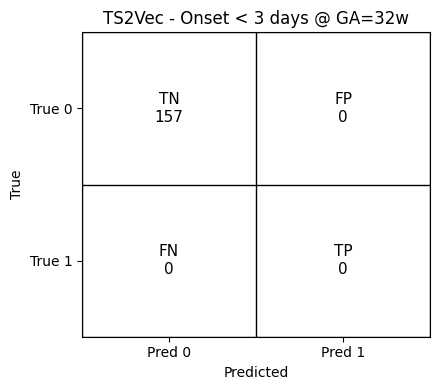


--- GA = 33 weeks ---
Samples = 254, Positives (y_true=1) = 4, Positive ratio = 0.0157
TP=0, TN=250, FP=0, FN=4
Sensitivity (TPR): 0.000
Specificity (TNR): 1.000
PPV: nan
NPV: 0.984
Accuracy: 0.984


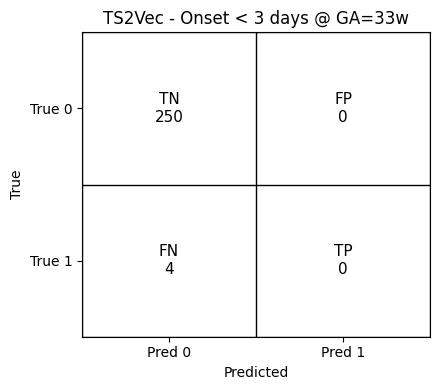


--- GA = 34 weeks ---
Samples = 313, Positives (y_true=1) = 0, Positive ratio = 0.0000
TP=0, TN=313, FP=0, FN=0
Sensitivity (TPR): nan
Specificity (TNR): 1.000
PPV: nan
NPV: 1.000
Accuracy: 1.000


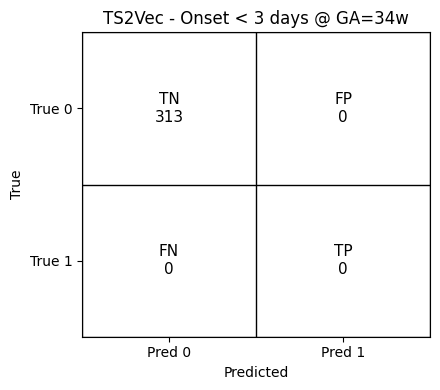


--- GA = 35 weeks ---
Samples = 371, Positives (y_true=1) = 0, Positive ratio = 0.0000
TP=0, TN=371, FP=0, FN=0
Sensitivity (TPR): nan
Specificity (TNR): 1.000
PPV: nan
NPV: 1.000
Accuracy: 1.000


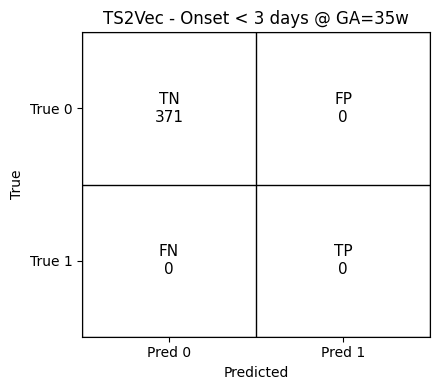


--- GA = 36 weeks ---
Samples = 443, Positives (y_true=1) = 0, Positive ratio = 0.0000
TP=0, TN=443, FP=0, FN=0
Sensitivity (TPR): nan
Specificity (TNR): 1.000
PPV: nan
NPV: 1.000
Accuracy: 1.000


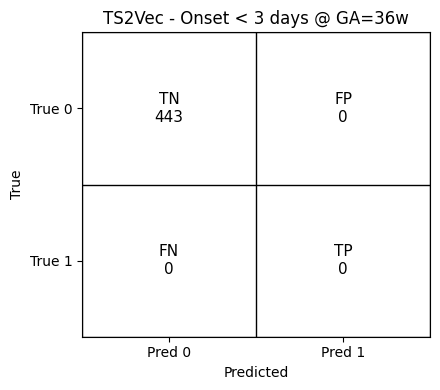


--- GA = 37 weeks ---
Samples = 503, Positives (y_true=1) = 10, Positive ratio = 0.0199
TP=0, TN=493, FP=0, FN=10
Sensitivity (TPR): 0.000
Specificity (TNR): 1.000
PPV: nan
NPV: 0.980
Accuracy: 0.980


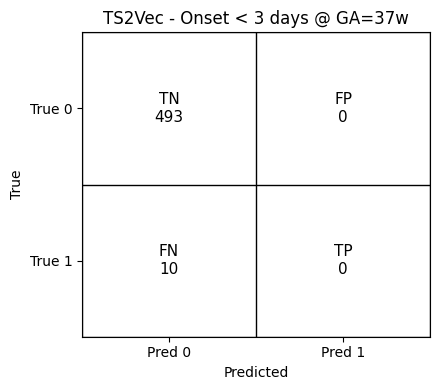


--- GA = 38 weeks ---
Samples = 544, Positives (y_true=1) = 19, Positive ratio = 0.0349
TP=0, TN=524, FP=1, FN=19
Sensitivity (TPR): 0.000
Specificity (TNR): 0.998
PPV: 0.000
NPV: 0.965
Accuracy: 0.963


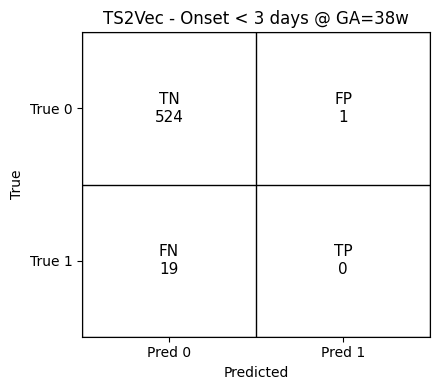


--- GA = 39 weeks ---
Samples = 463, Positives (y_true=1) = 77, Positive ratio = 0.1663
TP=2, TN=377, FP=9, FN=75
Sensitivity (TPR): 0.026
Specificity (TNR): 0.977
PPV: 0.182
NPV: 0.834
Accuracy: 0.819


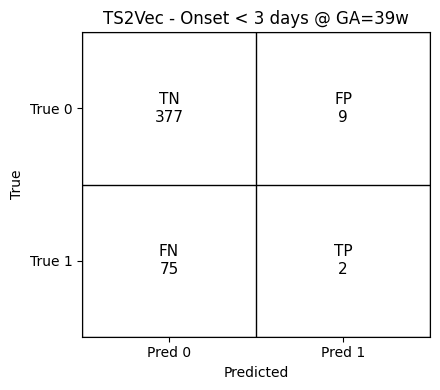


--- GA = 40 weeks ---
Samples = 321, Positives (y_true=1) = 72, Positive ratio = 0.2243
TP=25, TN=174, FP=75, FN=47
Sensitivity (TPR): 0.347
Specificity (TNR): 0.699
PPV: 0.250
NPV: 0.787
Accuracy: 0.620


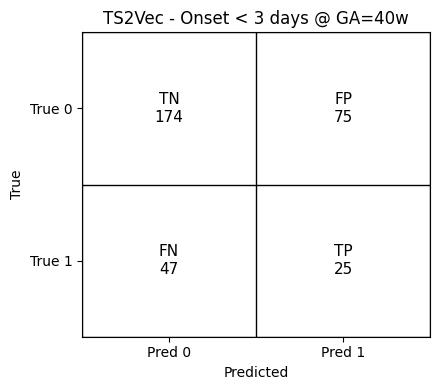


--- GA = 41 weeks ---
Samples = 89, Positives (y_true=1) = 45, Positive ratio = 0.5056
TP=37, TN=4, FP=40, FN=8
Sensitivity (TPR): 0.822
Specificity (TNR): 0.091
PPV: 0.481
NPV: 0.333
Accuracy: 0.461


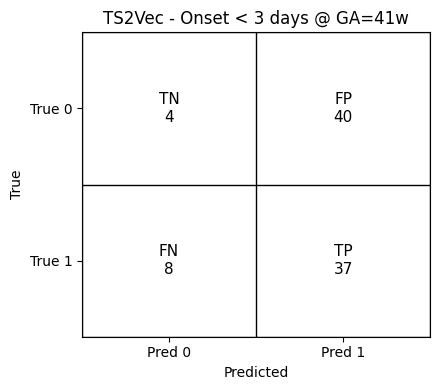


--- GA = 42 weeks ---
Samples = 1, Positives (y_true=1) = 1, Positive ratio = 1.0000
TP=1, TN=0, FP=0, FN=0
Sensitivity (TPR): 1.000
Specificity (TNR): nan
PPV: 1.000
NPV: nan
Accuracy: 1.000


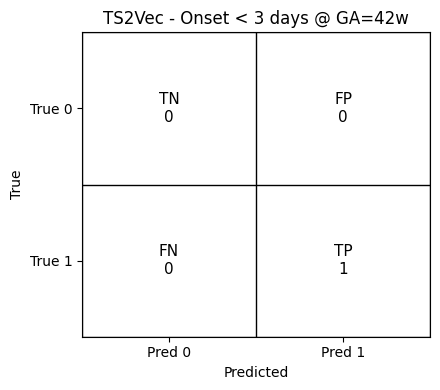

In [12]:
TRUE_THRESH = 3.0   # 真实阈值，用于定义正例：y_true < TRUE_THRESH
PRED_THRESH = 4.0   # 预测判阳阈值：y_pred < PRED_THRESH

file_map = {
    ("SuperCNN", "onset"): "cnn_prediction.csv",
    ("TS2Vec",   "onset"): "ts2vec_prediction.csv",
    # ("SuperCNN", "add"):   "prediction_superCNN_add.csv",
    # ("TS2Vec",   "add"):   "prediction_TS2Vec_add.csv",
}

def binarize(y_true, y_pred):
    """
    根据真实和预测的天数，二值化为 0/1。
    y_true_bin: 真实是否为阳性 (天数 < TRUE_THRESH)
    y_pred_bin: 预测是否为阳性 (天数 < PRED_THRESH)
    """
    y_true_bin = (y_true < TRUE_THRESH).astype(int)
    y_pred_bin = (y_pred < PRED_THRESH).astype(int)
    return y_true_bin, y_pred_bin

def compute_confusion(y_true_bin, y_pred_bin):
    tp = int(((y_true_bin == 1) & (y_pred_bin == 1)).sum())
    tn = int(((y_true_bin == 0) & (y_pred_bin == 0)).sum())
    fp = int(((y_true_bin == 0) & (y_pred_bin == 1)).sum())
    fn = int(((y_true_bin == 1) & (y_pred_bin == 0)).sum())
    return tp, tn, fp, fn

def compute_metrics(tp, tn, fp, fn):
    total = tp + tn + fp + fn
    sens = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    spec = tn / (tn + fp) if (tn + fp) > 0 else np.nan
    ppv  = tp / (tp + fp) if (tp + fp) > 0 else np.nan
    npv  = tn / (tn + fn) if (tn + fn) > 0 else np.nan
    acc  = (tp + tn) / total if total > 0 else np.nan
    return sens, spec, ppv, npv, acc

def plot_confusion(tp, tn, fp, fn, title_suffix):
    cm = np.array([[tn, fp],
                   [fn, tp]])
    labels = [["TN", "FP"],
              ["FN", "TP"]]

    fig, ax = plt.subplots(figsize=(4.5, 4))

    ax.set_xlim(-0.5, 1.5)
    ax.set_ylim(1.5, -0.5)

    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["Pred 0", "Pred 1"])
    ax.set_yticklabels(["True 0", "True 1"])

    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(title_suffix)

    # 画网格线
    for i in range(2):
        ax.axhline(i - 0.5, color="black", linewidth=1)
        ax.axvline(i - 0.5, color="black", linewidth=1)
    ax.axhline(1.5, color="black", linewidth=1)
    ax.axvline(1.5, color="black", linewidth=1)

    # 写上 TN/FP/FN/TP 和数值
    for i in range(2):
        for j in range(2):
            ax.text(
                j, i,
                f"{labels[i][j]}\n{cm[i, j]}",
                ha="center", va="center",
                fontsize=11
            )

    plt.tight_layout()
    plt.show()

for model, target in [
    ("SuperCNN", "onset"),
    ("TS2Vec",   "onset"),
    # ("SuperCNN", "add"),
    # ("TS2Vec",   "add"),
]:
    path = file_map[(model, target)]
    df = pd.read_csv(path)

    if "gest_age_weeks" not in df.columns:
        raise KeyError(f"{path} 中未找到 'gest_age_weeks' 列！")

    print("\n" + "=" * 80)
    print(f"### {model} - {target} 按 gest_age_weeks 分层分析 (true<{TRUE_THRESH}, pred<{PRED_THRESH} 天) ###")

    # 按孕周排序后的唯一取值
    weeks = sorted(df["gest_age_weeks"].dropna().unique())

    for wk in weeks:
        df_w = df[df["gest_age_weeks"] == wk]

        if len(df_w) == 0:
            continue

        y_true = df_w["y_true"].to_numpy()
        y_pred = df_w["y_pred"].to_numpy()

        # 二值化
        y_true_bin, y_pred_bin = binarize(y_true, y_pred)

        # 样本数与正例比例
        n_total = len(y_true_bin)
        n_pos   = int(y_true_bin.sum())
        pos_ratio = n_pos / n_total if n_total > 0 else np.nan

        print(f"\n--- GA = {wk} weeks ---")
        print(f"Samples = {n_total}, Positives (y_true=1) = {n_pos}, Positive ratio = {pos_ratio:.4f}")

        # confusion matrix 和指标
        tp, tn, fp, fn = compute_confusion(y_true_bin, y_pred_bin)
        sens, spec, ppv, npv, acc = compute_metrics(tp, tn, fp, fn)

        print(f"TP={tp}, TN={tn}, FP={fp}, FN={fn}")
        print(f"Sensitivity (TPR): {sens:.3f}")
        print(f"Specificity (TNR): {spec:.3f}")
        print(f"PPV: {ppv:.3f}")
        print(f"NPV: {npv:.3f}")
        print(f"Accuracy: {acc:.3f}")

        # 画该孕周的 confusion matrix
        if target == "onset":
            task_name = "Onset"
        else:
            task_name = "ADD"

        title_suffix = f"{model} - {task_name} < {int(TRUE_THRESH)} days @ GA={wk}w"
        plot_confusion(tp, tn, fp, fn, title_suffix)
